<a href="https://colab.research.google.com/github/pratik-poudel/datacrunch/blob/main/28th%20march%20converting%20to%20time%20series%20and%20predicting%20with%20MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import gc
# pd.options.display.float_format| = "{:.2f}".format
pd.options.display.max_columns = 500


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import requests
from scipy import stats

import lightgbm as lgb

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [56]:
train_datalink_X = 'https://tournament.datacrunch.com/data/X_train.csv'  
train_datalink_y = 'https://tournament.datacrunch.com/data/y_train.csv'
hackathon_data_link = 'https://tournament.datacrunch.com/data/X_test.csv'

In [112]:
train = pd.read_csv(train_datalink_X)
target = pd.read_csv(train_datalink_y)
test = pd.read_csv(hackathon_data_link)

In [58]:
train = pd.concat([train, target], axis=1)

In [59]:
train.shape

(14687, 17)

In [60]:
validation_data = train[13000: ]
train_data = train[:13000]

In [61]:
features = [f for f in train_data.columns if 'Feature' in f]
len(features)

14

In [62]:
train_data.shape

(13000, 17)

# TRAINING

In [63]:
def scorer(y_test, y_pred):
    score = (stats.spearmanr(y_test, y_pred))[0]
    # print('Score as calculated for the leader board (っಠ‿ಠ)っ {}'.format(score))
    return score

In [64]:
# train[:10][['Feature_1', 'target_r']]

In [65]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()   
    for i in range(len(sequences)):
# find the end of this pattern
        end_ix = i + n_steps
# check if we are beyond the dataset
        if end_ix > len(sequences):
            break
# gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-3], sequences[end_ix-1, -3:]
        # print(seq_x)
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [66]:
train_data_arr = np.array(train_data)
validation_data_arr = np.array(validation_data)

In [67]:
train_data_arr.shape, validation_data_arr.shape

((13000, 17), (1687, 17))

In [68]:
%matplotlib inline
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [69]:
np.random.seed(60)
df = []
for i in range(1,30):
    n_steps = i
    X_train, y_train = split_sequences(train_data_arr, n_steps)
    X_val, y_val = split_sequences(validation_data_arr, n_steps)

    n_input = X_train.shape[1] * X_train.shape[2]
    X_train = X_train.reshape((X_train.shape[0], n_input))
    X_val = X_val.reshape((X_val.shape[0], n_input))

    from keras.models import Sequential
    from keras.layers import Dense


    model = Sequential()
    model.add(Dense(1024, activation='sigmoid', input_dim=n_input))
    model.add(Dense(512, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(150, activation='relu'))
    # model.add(Dense(50, activation='relu'))
    model.add(Dense(3))
    model.compile(optimizer='rmsprop', loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
    mcp_save = ModelCheckpoint('./model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

    batch_size = 64
    epochs = 250

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,verbose=0, validation_data=(X_val, y_val), 
                        callbacks=[early_stopping, mcp_save], shuffle=False)

    
    # plot_metric(history, 'loss')
    print( "TIME STEPS : --------> " , i)

    model.load_weights('model.hdf5')
    preds= model.predict(X_val, batch_size=batch_size)
    cols = ['target_r', 'target_g', 'target_b']
    preds = pd.DataFrame(preds, columns=cols)

    scores = []
    scores.append(n_steps)
    scores.append(scorer(y_val[:, 0], preds.target_r))
    scores.append(scorer(y_val[:, 1], preds.target_g))
    scores.append(scorer(y_val[:, 2], preds.target_b))
    df.append(pd.DataFrame(scores))

Epoch 00035: early stopping
TIME STEPS : -------->  1
Epoch 00048: early stopping
TIME STEPS : -------->  2
Epoch 00037: early stopping
TIME STEPS : -------->  3
Epoch 00031: early stopping
TIME STEPS : -------->  4
Epoch 00051: early stopping
TIME STEPS : -------->  5
Epoch 00057: early stopping
TIME STEPS : -------->  6
Epoch 00059: early stopping
TIME STEPS : -------->  7
Epoch 00052: early stopping
TIME STEPS : -------->  8
Epoch 00016: early stopping
TIME STEPS : -------->  9
Epoch 00018: early stopping
TIME STEPS : -------->  10
Epoch 00017: early stopping
TIME STEPS : -------->  11
Epoch 00016: early stopping
TIME STEPS : -------->  12
Epoch 00016: early stopping
TIME STEPS : -------->  13
Epoch 00016: early stopping
TIME STEPS : -------->  14
Epoch 00016: early stopping
TIME STEPS : -------->  15
Epoch 00017: early stopping
TIME STEPS : -------->  16
Epoch 00016: early stopping
TIME STEPS : -------->  17
Epoch 00027: early stopping
TIME STEPS : -------->  18
Epoch 00016: early 

In [70]:
df = pd.concat(df, axis=1)
df.columns = df.iloc[0]
df.drop(df.index[0], inplace=True)

In [71]:
df.T

,1,2,3
0,,,
1.0,0.069022,0.139454,0.090283
2.0,0.084482,0.151932,0.115996
3.0,0.096924,0.143710,0.095952
4.0,0.056247,0.150244,0.109253
5.0,0.098886,0.146413,0.089365
6.0,0.145689,0.165880,0.099518
7.0,0.070272,0.147437,0.086676
8.0,0.088554,0.136054,0.095780
9.0,0.021500,0.108197,0.075088


In [72]:
df.T.max()

1    0.145689
2    0.184481
3    0.115996
dtype: float64

In [128]:
train = pd.read_csv(train_datalink_X)
target = pd.read_csv(train_datalink_y)
test = pd.read_csv(hackathon_data_link)

In [129]:
train = pd.concat([train, target], axis=1)

In [130]:
train.shape

(14687, 17)

In [131]:
validation_data = train[13000: ]
train_data = train[:13000]

In [132]:
features = [f for f in train_data.columns if 'Feature' in f]
len(features)

14

In [134]:
validation_data.shape[0] - 6

1681

In [135]:
test_merge = validation_data[1682:]
cols

['target_r', 'target_g', 'target_b']

In [136]:
cols = ['target_r', 'target_g', 'target_b']
test_merge.drop(columns=cols, inplace=True)

In [137]:
validation_data = validation_data[:1682]

In [138]:
train_data_arr = np.array(train_data)
validation_data_arr = np.array(validation_data)
validation_data_arr.shape

(1682, 17)

Epoch 00021: early stopping


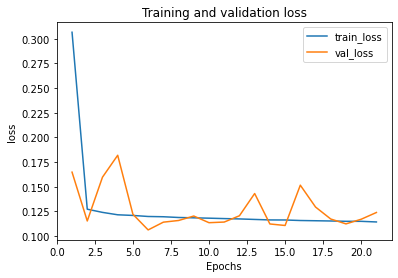

0.12411323168316316
0.19117337588327812
0.15196726653555218


In [139]:
np.random.seed(60)
n_steps = 6
X_train, y_train = split_sequences(train_data_arr, n_steps)
X_val, y_val = split_sequences(validation_data_arr, n_steps)

n_input = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape((X_train.shape[0], n_input))
X_val = X_val.reshape((X_val.shape[0], n_input))

from keras.models import Sequential
from keras.layers import Dense


model = Sequential()
model.add(Dense(1024, activation='sigmoid', input_dim=n_input))
model.add(Dense(512, activation='relu'))
# model.add(Dense(256, activation='relu'))
model.add(Dense(150, activation='relu'))
# model.add(Dense(50, activation='relu'))
model.add(Dense(3))
model.compile(optimizer='rmsprop', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mcp_save = ModelCheckpoint('./model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

batch_size = 64
epochs = 250

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,verbose=0, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, mcp_save], shuffle=True)


plot_metric(history, 'loss')

model.load_weights('model.hdf5')
preds= model.predict(X_val, batch_size=batch_size)
cols = ['target_r', 'target_g', 'target_b']
preds = pd.DataFrame(preds, columns=cols)

print(scorer(y_val[:, 0], preds.target_r))
print(scorer(y_val[:, 1], preds.target_g))
print(scorer(y_val[:, 2], preds.target_b))

In [141]:
test_data_with_lag = pd.concat([test_merge, test])
test_data_with_lag.shape

(14448, 14)

In [142]:
def split_sequences_for_prediction(sequences, n_steps):
    X= list()   
    for i in range(len(sequences)):
# find the end of this pattern
        end_ix = i + n_steps
# check if we are beyond the dataset
        if end_ix > len(sequences):
            break
# gather input and output parts of the pattern
        seq_x =sequences[i:end_ix]
        # print(seq_x)
        X.append(seq_x)
    return np.array(X)

In [143]:
preds_data = split_sequences_for_prediction(np.array(test_data_with_lag), 6)

In [144]:
preds_data.shape

(14443, 6, 14)

In [145]:
preds_data = preds_data.reshape((preds_data.shape[0], n_input))
preds_data.shape

(14443, 84)

In [149]:
prediction = pd.DataFrame(model.predict(preds_data, batch_size=batch_size))

In [151]:
prediction.columns = cols

In [152]:
prediction

,target_r,target_g,target_b
0,0.594658,0.759916,0.657480
1,0.580761,0.750742,0.651872
2,0.564168,0.684659,0.585546
3,0.592176,0.688702,0.586661
4,0.633845,0.760157,0.670234
...,...,...,...
14438,0.517283,0.581733,0.483926
14439,0.589078,0.710652,0.608190
14440,0.568735,0.670176,0.565338
14441,0.619641,0.720944,0.620316


# Predictions

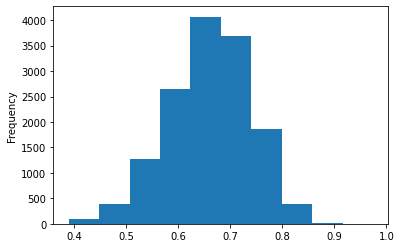

In [153]:
prediction['target_g'].plot(kind='hist')

In [154]:
API_KEY = "0GIskIC9Rd1I8sMw6nStutbIbMx7AaZzAyNfuMOVAVWgJtNa1IVQHZAD3WPj" # <- HERE

r = requests.post("https://tournament.datacrunch.com/api/submission",
    files = {
        "file": ("x", prediction.to_csv().encode('ascii'))
    },
    data = {
        "apiKey": API_KEY
    },
)

if r.status_code == 200:
    print("Submission submitted :)")
elif r.status_code == 423:
    print("ERR: Submissions are close")
    print("You can only submit during rounds eg: Friday 7pm GMT+1 to Sunday midnight GMT+1.")
    print("Or the server is currently crunching the submitted files, please wait some time before retrying.")
elif r.status_code == 422:
    print("ERR: API Key is missing or empty")
    print("Did you forget to fill the API_KEY variable?")
elif r.status_code == 404:
    print("ERR: Unknown API Key")
    print("You should check that the provided API key is valid and is the same as the one you've received by email.")
elif r.status_code == 400:
    print("ERR: The file must not be empty")
    print("You have send a empty file.")
elif r.status_code == 401:
    print("ERR: Your email hasn't been verified")
    print("Please verify your email or contact a cruncher.")
elif r.status_code == 429:
    print("ERR: Too many submissions")
else:
    print("ERR: Server returned: " + str(r.status_code))
    print("Ouch! It seems that we were not expecting this kind of result from the server, if the probleme persist, contact a cruncher.")

Submission submitted :)
